In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
def make_moons_manual(n_samples=100, noise=0.0, random_state=None):
    
    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random.RandomState()

    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    outer_circ_theta = np.linspace(0, np.pi, n_samples_out)
    X_outer = np.vstack([np.cos(outer_circ_theta), np.sin(outer_circ_theta)]).T
    y_outer = np.zeros(n_samples_out, dtype=int)

    inner_circ_theta = np.linspace(0, np.pi, n_samples_in)
    X_inner = np.vstack([1 - np.cos(inner_circ_theta), 0.5 - np.sin(inner_circ_theta)]).T
    y_inner = np.ones(n_samples_in, dtype=int)

    # Combine
    X = np.vstack([X_outer, X_inner])
    y = np.concatenate([y_outer, y_inner])

    # Add noise
    if noise is not None and noise > 0:
        X += rng.normal(scale=noise, size=X.shape)

    return X, y

In [ ]:

X_train_full, y_train_full = make_moons_manual(n_samples=500, noise=0.2, random_state=SEED)
X_test_02, y_test_02 = make_moons_manual(n_samples=500, noise=0.2, random_state=SEED + 1)

X_test_01, y_test_01 = make_moons_manual(n_samples=500, noise=0.1, random_state=SEED + 2)
X_test_03, y_test_03 = make_moons_manual(n_samples=500, noise=0.3, random_state=SEED + 3)

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)

X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_full_scaled, y_train_full, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_train_full
)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32)
X_test_02_t = torch.tensor(X_test_02_scaled, dtype=torch.float32)
X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32)

In [ ]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

def evaluate_mlp(model, X_test_t, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test_t).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().numpy()
        probs_numpy = probs.numpy()
    
    accuracy = accuracy_score(y_test, preds)
    auroc = roc_auc_score(y_test, probs_numpy)
    return accuracy, auroc

In [ ]:
print("Training Model 1: MLP + Early Stopping")
model_mlp_es = MLP(hidden_size=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_mlp_es.parameters(), lr=0.01)

patience = 50
epochs = 2000
best_val_loss = float('inf')
epochs_no_improve = 0
best_weights = None

for epoch in range(epochs):
    model_mlp_es.train()
    y_pred = model_mlp_es(X_train_t).squeeze()
    loss = criterion(y_pred, y_train_t.squeeze())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    model_mlp_es.eval()
    with torch.no_grad():
        y_val_pred = model_mlp_es(X_val_t).squeeze()
        val_loss = criterion(y_val_pred, y_val_t.squeeze())
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_weights = model_mlp_es.state_dict()
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve == patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

model_mlp_es.load_state_dict(best_weights)
print("Model 1 training complete.")

Training Model 1: MLP + Early Stopping
Early stopping at epoch 361
Model 1 training complete.



Training Model 2: MLP + L1 Regularization (Grid Search)
Best L1 Lambda: 3e-05


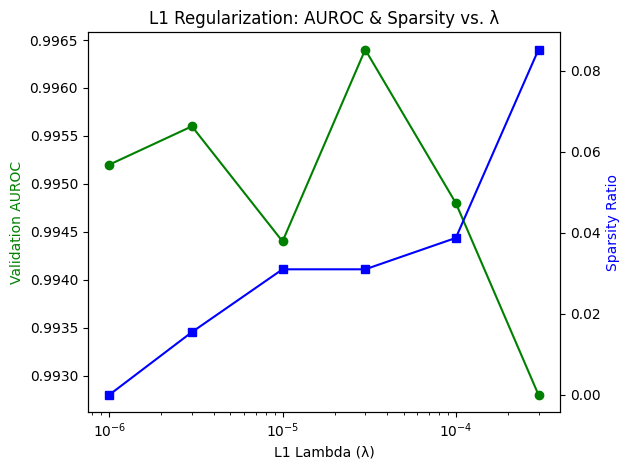

In [ ]:
print("\nTraining Model 2: MLP + L1 Regularization (Grid Search)")
lambda_grid_l1 = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs_l1 = []
models_l1 = {}
sparsity_l1 = []

for lambda_val in lambda_grid_l1:
    model = MLP(hidden_size=32)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    for epoch in range(1000): 
        model.train()
        y_pred = model(X_train_t).squeeze()
        
        # Calculate L1 loss
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        bce_loss = criterion(y_pred, y_train_t.squeeze())
        loss = bce_loss + lambda_val * l1_norm
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    _, val_auroc = evaluate_mlp(model, X_val_t, y_val)
    val_aurocs_l1.append(val_auroc)
    models_l1[lambda_val] = model.state_dict()
    
    total_weights = 0
    zero_weights = 0
    with torch.no_grad():
        for param in model.parameters():
            total_weights += param.numel()
            zero_weights += (param.abs() < 1e-4).sum().item()
    sparsity_l1.append(zero_weights / total_weights)

# Select best L1 model
best_lambda_l1 = lambda_grid_l1[np.argmax(val_aurocs_l1)]
model_mlp_l1 = MLP(hidden_size=32)
model_mlp_l1.load_state_dict(models_l1[best_lambda_l1])
print(f"Best L1 Lambda: {best_lambda_l1}")

# Plot L1 Grid Search Results
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(lambda_grid_l1, val_aurocs_l1, 'g-o', label='Validation AUROC')
ax2.plot(lambda_grid_l1, sparsity_l1, 'b-s', label='Sparsity (weights < 1e-4)')
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC', color='g')
ax2.set_ylabel('Sparsity Ratio', color='b')
plt.title('L1 Regularization: AUROC & Sparsity vs. λ')
fig.tight_layout()
plt.show()

In [ ]:
print("\nTraining Model 3: MLP + L2 Regularization (Grid Search)")
lambda_grid_l2 = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.3]
val_aurocs_l2 = []
models_l2 = {}

for lambda_val in lambda_grid_l2:
    model = MLP(hidden_size=32)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_val)
    
    for epoch in range(1000): 
        model.train()
        y_pred = model(X_train_t).squeeze()
        loss = criterion(y_pred, y_train_t.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Evaluate on validation set
    _, val_auroc = evaluate_mlp(model, X_val_t, y_val)
    val_aurocs_l2.append(val_auroc)
    models_l2[lambda_val] = model.state_dict()

# Select best L2 model
best_lambda_l2 = lambda_grid_l2[np.argmax(val_aurocs_l2)]
model_mlp_l2 = MLP(hidden_size=32)
model_mlp_l2.load_state_dict(models_l2[best_lambda_l2])
print(f"Best L2 Lambda (Weight Decay): {best_lambda_l2}")


Training Model 3: MLP + L2 Regularization (Grid Search)
Best L2 Lambda (Weight Decay): 0.001


In [ ]:
print("\nTraining Model 4: Logistic Regression + Polynomial Features")

# Create the pipeline
pipeline_logreg = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver='liblinear', random_state=SEED))
])

logreg_grid = {'model__C': [0.01, 0.1, 1, 10, 100]}


X_train_val_unscaled = scaler.inverse_transform(np.concatenate((X_train_scaled, X_val_scaled)))
y_train_val = np.concatenate((y_train, y_val))

test_fold = np.array([-1] * len(y_train) + [0] * len(y_val))
ps = PredefinedSplit(test_fold=test_fold)

# Run GridSearch
grid_search_logreg = GridSearchCV(
    pipeline_logreg, 
    logreg_grid, 
    cv=ps, 
    scoring='roc_auc', 
    n_jobs=-1
)
grid_search_logreg.fit(X_train_val_unscaled, y_train_val)

model_logreg_pipeline = grid_search_logreg.best_estimator_
print(f"Best LogReg C: {grid_search_logreg.best_params_['model__C']}")
print("Model 4 training complete.")


Training Model 4: Logistic Regression + Polynomial Features
Best LogReg C: 100
Model 4 training complete.


In [ ]:
models_to_evaluate = {
    'MLP (Early Stop)': (model_mlp_es, 'torch'),
    'MLP (L1)': (model_mlp_l1, 'torch'),
    'MLP (L2)': (model_mlp_l2, 'torch'),
    'LogReg (Poly)': (model_logreg_pipeline, 'sklearn')
}

test_sets = {
    'Noise 0.10': (X_test_01_t, y_test_01, X_test_01), 
    'Noise 0.20': (X_test_02_t, y_test_02, X_test_02),
    'Noise 0.30': (X_test_03_t, y_test_03, X_test_03)
}

results = {}

for model_name, (model, model_type) in models_to_evaluate.items():
    model_accuracies = {}
    for test_name, (X_t, y, X) in test_sets.items():
        if model_type == 'torch':
            acc, _ = evaluate_mlp(model, X_t, y)
        else: 
            acc = accuracy_score(y, model.predict(X))
        model_accuracies[test_name] = acc
    results[model_name] = model_accuracies

mlp_params = sum(p.numel() for p in model_mlp_es.parameters() if p.requires_grad)
logreg_params = model_logreg_pipeline.named_steps['model'].coef_.size + 1 

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results['Param Count'] = [mlp_params, mlp_params, mlp_params, logreg_params]

print("\n--- Test Accuracy and Robustness ---")
print(df_results.to_markdown(floatfmt=".3f"))


--- Test Accuracy and Robustness ---
|                  |   Noise 0.10 |   Noise 0.20 |   Noise 0.30 |   Param Count |
|:-----------------|-------------:|-------------:|-------------:|--------------:|
| MLP (Early Stop) |        0.998 |        0.968 |        0.906 |       129.000 |
| MLP (L1)         |        1.000 |        0.972 |        0.904 |       129.000 |
| MLP (L2)         |        0.996 |        0.966 |        0.908 |       129.000 |
| LogReg (Poly)    |        0.994 |        0.962 |        0.904 |        10.000 |


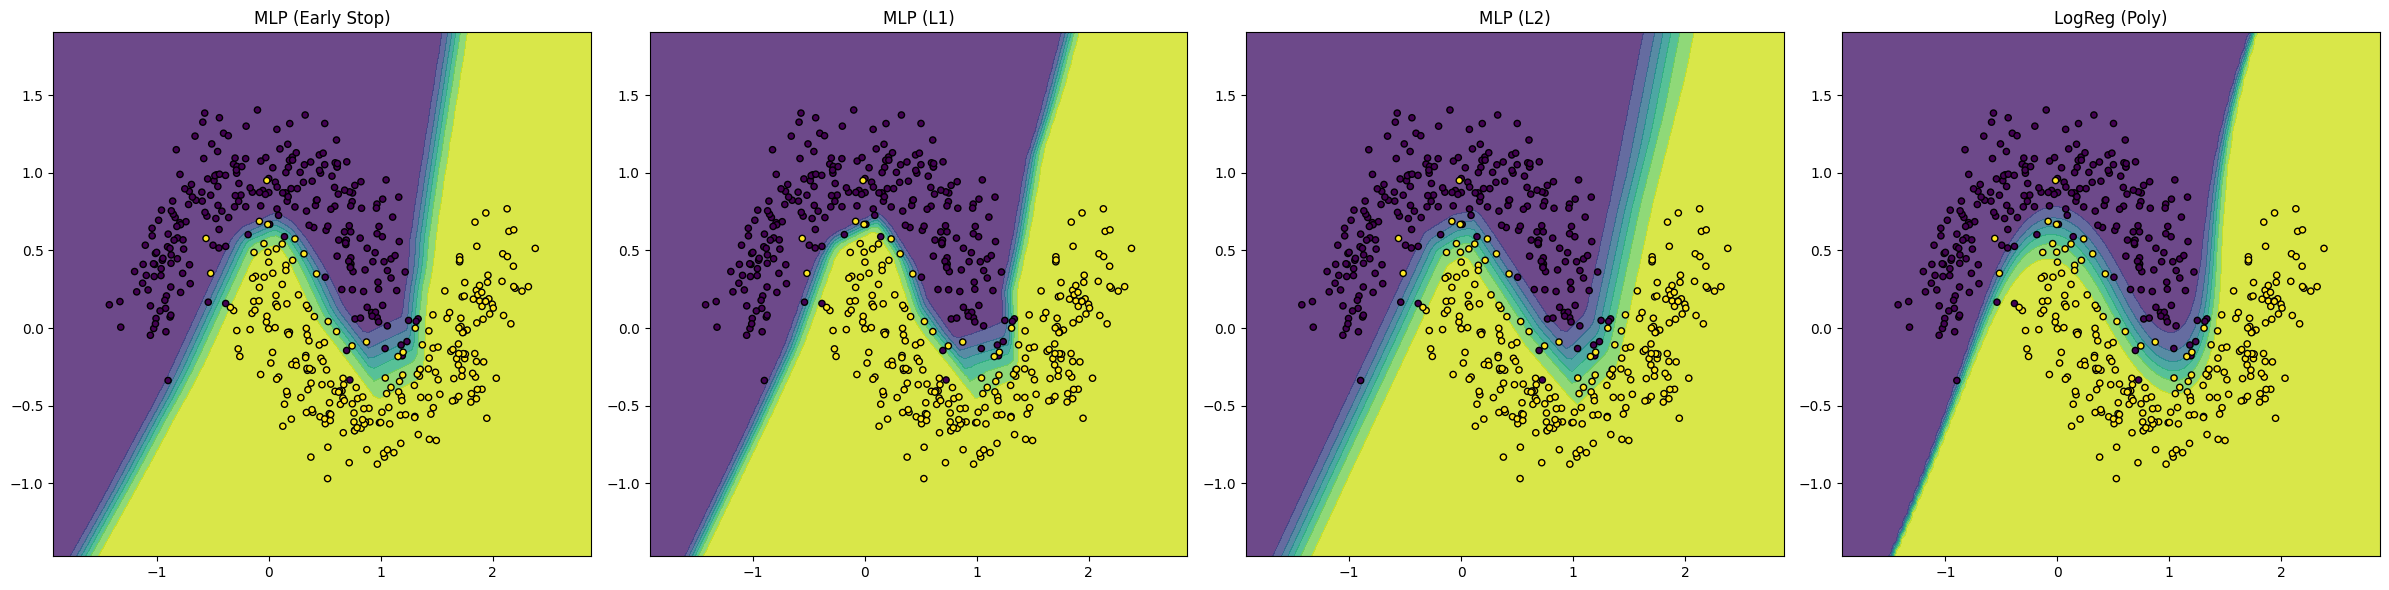

In [ ]:
def plot_decision_boundary(model, X, y, ax, title, model_type, scaler=None, pipeline=None):
    """
    Plots the decision boundary in the *original* data space.
    """
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points_orig = np.c_[xx.ravel(), yy.ravel()]
    
    Z = None
    if model_type == 'torch':
        grid_points_scaled = scaler.transform(grid_points_orig)
        grid_points_t = torch.tensor(grid_points_scaled, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            Z = torch.sigmoid(model(grid_points_t).squeeze()).numpy()
    
    elif model_type == 'sklearn':
        Z = pipeline.predict_proba(grid_points_orig)[:, 1]
    
    Z = Z.reshape(xx.shape)
    
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    ax.contourf(xx, yy, Z, cmap='viridis', alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20, edgecolors='k')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

plot_decision_boundary(model_mlp_es, X_test_02, y_test_02, axes[0], 
                       'MLP (Early Stop)', 'torch', scaler=scaler)
plot_decision_boundary(model_mlp_l1, X_test_02, y_test_02, axes[1], 
                       'MLP (L1)', 'torch', scaler=scaler)
plot_decision_boundary(model_mlp_l2, X_test_02, y_test_02, axes[2], 
                       'MLP (L2)', 'torch', scaler=scaler)
plot_decision_boundary(None, X_test_02, y_test_02, axes[3], 
                       'LogReg (Poly)', 'sklearn', pipeline=model_logreg_pipeline)

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Class Imbalance Experiment (70:30) ---")

idx_0 = np.where(y_train_full == 0)[0]
idx_1 = np.where(y_train_full == 1)[0]

rng = np.random.RandomState(SEED)
idx_1_sub = rng.choice(idx_1, size=107, replace=False)
idx_imbalanced = np.concatenate([idx_0, idx_1_sub])

X_train_full_imb = X_train_full[idx_imbalanced]
y_train_full_imb = y_train_full[idx_imbalanced]

print(f"Imbalanced set created: {len(idx_0)} class 0 ({(len(idx_0)/len(idx_imbalanced)*100):.1f}%) "
      f"and {len(idx_1_sub)} class 1 ({(len(idx_1_sub)/len(idx_imbalanced)*100):.1f}%)")

scaler_imb = StandardScaler()
X_train_full_imb_scaled = scaler_imb.fit_transform(X_train_full_imb)

X_train_imb_scaled, X_val_imb_scaled, y_train_imb, y_val_imb = train_test_split(
    X_train_full_imb_scaled, y_train_full_imb, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=y_train_full_imb
)

X_train_imb_t = torch.tensor(X_train_imb_scaled, dtype=torch.float32)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.float32).view(-1, 1)
X_val_imb_t = torch.tensor(X_val_imb_scaled, dtype=torch.float32)
y_val_imb_t = torch.tensor(y_val_imb, dtype=torch.float32).view(-1, 1)

X_test_02_scaled_imb = scaler_imb.transform(X_test_02)
X_test_02_t_imb = torch.tensor(X_test_02_scaled_imb, dtype=torch.float32)

print("Re-training models on imbalanced data...")

model_mlp_es_imb = MLP(hidden_size=32)
optimizer = optim.Adam(model_mlp_es_imb.parameters(), lr=0.01)
best_val_loss = float('inf')
epochs_no_improve = 0
for epoch in range(epochs):
    model_mlp_es_imb.train()
    y_pred = model_mlp_es_imb(X_train_imb_t).squeeze()
    loss = criterion(y_pred, y_train_imb_t.squeeze())
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    model_mlp_es_imb.eval()
    with torch.no_grad():
        val_loss = criterion(model_mlp_es_imb(X_val_imb_t).squeeze(), y_val_imb_t.squeeze())
    if val_loss < best_val_loss:
        best_val_loss = val_loss; epochs_no_improve = 0; best_weights = model_mlp_es_imb.state_dict()
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience: break
model_mlp_es_imb.load_state_dict(best_weights)

model_mlp_l1_imb = MLP(hidden_size=32)
optimizer = optim.Adam(model_mlp_l1_imb.parameters(), lr=0.01)
for epoch in range(1000):
    model_mlp_l1_imb.train()
    y_pred = model_mlp_l1_imb(X_train_imb_t).squeeze()
    l1_norm = sum(p.abs().sum() for p in model_mlp_l1_imb.parameters())
    loss = criterion(y_pred, y_train_imb_t.squeeze()) + best_lambda_l1 * l1_norm
    optimizer.zero_grad(); loss.backward(); optimizer.step()

model_mlp_l2_imb = MLP(hidden_size=32)
optimizer = optim.Adam(model_mlp_l2_imb.parameters(), lr=0.01, weight_decay=best_lambda_l2)
for epoch in range(1000):
    model_mlp_l2_imb.train()
    y_pred = model_mlp_l2_imb(X_train_imb_t).squeeze()
    loss = criterion(y_pred, y_train_imb_t.squeeze())
    optimizer.zero_grad(); loss.backward(); optimizer.step()

model_logreg_pipeline_imb = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=grid_search_logreg.best_params_['model__C'], solver='liblinear', random_state=SEED))
])
model_logreg_pipeline_imb.fit(X_train_full_imb, y_train_full_imb)

print("Re-training complete.")

imb_results = {}
imb_results['MLP (Early Stop)'] = evaluate_mlp(model_mlp_es_imb, X_test_02_t_imb, y_test_02)
imb_results['MLP (L1)'] = evaluate_mlp(model_mlp_l1_imb, X_test_02_t_imb, y_test_02)
imb_results['MLP (L2)'] = evaluate_mlp(model_mlp_l2_imb, X_test_02_t_imb, y_test_02)

y_pred_logreg_imb = model_logreg_pipeline_imb.predict(X_test_02)
y_proba_logreg_imb = model_logreg_pipeline_imb.predict_proba(X_test_02)[:, 1]
imb_results['LogReg (Poly)'] = (
    accuracy_score(y_test_02, y_pred_logreg_imb),
    roc_auc_score(y_test_02, y_proba_logreg_imb)
)

df_imb_results = pd.DataFrame.from_dict(imb_results, orient='index', columns=['Accuracy', 'AUROC'])
print("\n--- Imbalanced-Train Model Results on Balanced Test Set (Noise 0.2) ---")
print(df_imb_results.to_markdown(floatfmt=".3f"))


--- Class Imbalance Experiment (70:30) ---
Imbalanced set created: 250 class 0 (70.0%) and 107 class 1 (30.0%)
Re-training models on imbalanced data...
Re-training complete.

--- Imbalanced-Train Model Results on Balanced Test Set (Noise 0.2) ---
|                  |   Accuracy |   AUROC |
|:-----------------|-----------:|--------:|
| MLP (Early Stop) |      0.960 |   0.994 |
| MLP (L1)         |      0.962 |   0.994 |
| MLP (L2)         |      0.958 |   0.993 |
| LogReg (Poly)    |      0.956 |   0.993 |
